<a href="https://colab.research.google.com/github/ShreyNaik123/GAN-Implementations/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
ds, ds_info = tfds.load('fashion_mnist', split='train', with_info=True) # as_supervised=True

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBU2HJM/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteBU2HJM/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [4]:
# ds.as_numpy_iterator().next().keys()

In [5]:
dataIterator= ds.as_numpy_iterator()

In [6]:
# brings back a new output every time
# dataIterator.next()

In [7]:
# scale the data
def scale(data):
    image = data['image']
    return image / 255

In [8]:
ds = ds.map(scale, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)
len(ds)

469

In [9]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [10]:
# single_data = ds.take(1)
# for image, label in single_data:
#   print(image.shape)
#   print(label)
#   break

In [11]:
# create the generator
def build_generator():
  model = tf.keras.Sequential([
      # block 1
      tf.keras.layers.Dense(7*7*128, input_dim=128),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Reshape((7,7,128)),

      # block 2 upsamping
      tf.keras.layers.UpSampling2D(),
      tf.keras.layers.Conv2D(128, 5, padding='same'),
      tf.keras.layers.LeakyReLU(0.2),

      # block 3 upsamping
      tf.keras.layers.UpSampling2D(),
      tf.keras.layers.Conv2D(128, 5, padding='same'),
      tf.keras.layers.LeakyReLU(0.2),

      # block 4 convolutional - to extract more features and add more parameters
      tf.keras.layers.Conv2D(128, 4, padding='same'),
      tf.keras.layers.LeakyReLU(0.2),

      # block 5 convolutional - to extract more features and add more parameters
      tf.keras.layers.Conv2D(128, 4, padding='same'),
      tf.keras.layers.LeakyReLU(0.2),

      # layer to change the channels to match the image shape
      # output layer for generator
      tf.keras.layers.Conv2D(1, 4, padding='same', activation='sigmoid') #why sigmoid even though there are multiple classes
      # here the generator is attempting to generate a image that is valid and is recognized as one by the discriminator
      # so bith the models use either 1 or 0 to see if the outut is valid or not
      # in case of generator if 1 is valid then it has to get to a value close to 1 to generate a valid image
      # conversly in case of discriminator it needs to find the differneces between the actual and the fake images given by the generator so it has to focus on 0 more
      # so they both use a different loss functions where G is focused on loss value wrt 1 and D is focused on loss value wrt 0

  ], name='generative_model')
  return model

In [12]:
test_generator = build_generator()
test_generator.summary()

Model: "generative_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                  

In [13]:
import numpy as np
test_images = test_generator.predict(np.random.randn(4,128,1)) #4 images of size (depth) 32 (as the input to generators are random values)

1/1 [==============================] - 8s 8s/step


In [14]:
test_images.shape

(4, 28, 28, 1)

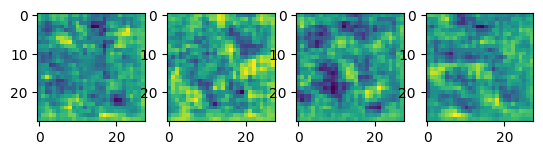

In [15]:
for i, image in enumerate(test_images):
  plt.subplot(1,4,i+1)
  plt.imshow(np.squeeze(image))

In [16]:
# discriminator model is basically a image classification model but for real or fake image
# this real fake logic will be implemented during custom training loops

def build_discriminator():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,5,input_shape=(28,28,1)),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.4), #adds regularization

        tf.keras.layers.Conv2D(64,5),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(128,5),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Conv2D(256,5),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(1, activation='sigmoid')

        ], name='discriminator')

    return model


In [17]:
test_discriminator = build_discriminator()

In [18]:
test_outputs = test_discriminator(test_images)

In [19]:
tf.squeeze(test_outputs).numpy()

array([0.49931577, 0.4991794 , 0.49908188, 0.4992821 ], dtype=float32)

In [20]:
# normal optimizers Adam is not compatible i think
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
# we need the lr of discriminator to be less so it learns slowly and gives time to the generator to develop better valid images
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [29]:
# CUSTOM CALLBACK
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      plt.subplot(1,3,i+1)
      plt.imshow(img)
      plt.axis(False)

In [30]:
from tensorflow.keras.models import Model

class GAN(Model):
  def __init__(self,generator,discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self,g_loss,g_opt,d_loss,d_opt, *args, **kwargs):
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.g_loss = g_loss
    self.d_loss = d_loss
    self.d_opt = d_opt


  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
    # why 128 128 1
    # first 128 is the number of images in a batch so 128 images
    # dk the reason for 2nd 128 will find

    # training the DISCRIMINATOR
    # start the gradient loop to record(watch) the values
    # used for automatic differentiation and gradient calculation
    with tf.GradientTape() as d_tape:
      # get the outputs from the discriminator the real and fake images
      y_real = self.discriminator(real_images, training=True)
      y_fake = self.discriminator(fake_images, training=True)
      y_pred = tf.concat([y_real, y_fake], axis=0)

      # create the true labels for the true and fake images
      # REAL -> 0 AND FAKE  -> 1 (can be anything)
      # as it is a success if it detects a fake
      y_true = tf.concat([tf.zeros_like(y_real), tf.ones_like(y_fake)], axis=0)

      # add some noise to the TRUE OUTPUTS to slow down discriminator and that generator has time to learn and generate valid images
      y_real_noise = 0.15*tf.random.uniform(tf.shape(y_real))
      y_fake_noise = -0.15*tf.random.uniform(tf.shape(y_fake))
      # +ve noise for real asn real -> 0 and dont want to go below that
      # negative noise for fake as fake -> 1 and dont want to go above that
      y_true += tf.concat([y_real_noise, y_fake_noise], axis=0)

      #calculate loss
      total_d_loss = self.d_loss(y_true, y_pred)




    # calculate d_gradient wrt to all the trainable parameters
    # backpropogate
    d_gradient = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)

    # # apply the gradients (optimize) wrt to the trainable parameters
    self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))


    # train the GENERATOR
    with tf.GradientTape() as g_tape:
      # generate random images
      generated_images = self.generator(tf.random.normal((128,128,1)), training=True)

      # get the predicted labels from discriminator
      y_pred = self.discriminator(generated_images, training=False)

      # set the actual lables for the images to be 0 we want the generator to think it always generates valid images
      # and then it learns from the discriminator
      y_true = tf.zeros_like(y_pred)

      # calculate the loss
      total_g_loss = self.g_loss(y_true, y_pred)

    # calculate the gradient
    # backpropogate
    g_gradient = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_gradient, self.generator.trainable_variables))


    return {'d_opt':total_d_loss,'g_opt':total_g_loss}

In [31]:
generator = build_generator()
discriminator = build_discriminator()

In [32]:
gan = GAN(generator, discriminator)

In [33]:
gan.compile(g_loss, g_opt, d_loss, d_opt)

In [34]:
if not os.path.exists('images'):
  os.mkdir('images')

Epoch 1/20
  6/469 [..............................] - ETA: 1:13 - d_opt: 0.6950 - g_opt: 0.6829

469/469 [==============================] - 80s 166ms/step - d_opt: 0.3956 - g_opt: 2.8741
Epoch 2/20
469/469 [==============================] - 78s 165ms/step - d_opt: 0.6597 - g_opt: 0.7191
Epoch 3/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.6064 - g_opt: 0.4870
Epoch 4/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.3809 - g_opt: 0.1159
Epoch 5/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.3176 - g_opt: 0.0309
Epoch 6/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.3522 - g_opt: 0.0489
Epoch 7/20
469/469 [==============================] - 78s 167ms/step - d_opt: 0.3549 - g_opt: 0.0965
Epoch 8/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.3063 - g_opt: 0.0446
Epoch 9/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.5852 - g_opt: 0.2739
Epoch 10/20
469/469 [==============================] - 78s 166ms/step - d_opt: 0.7005 - g_opt: 0.6261


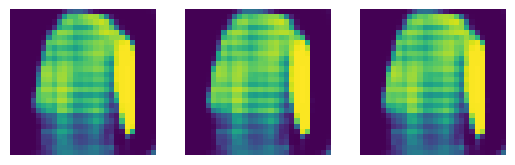

In [35]:
hist = gan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

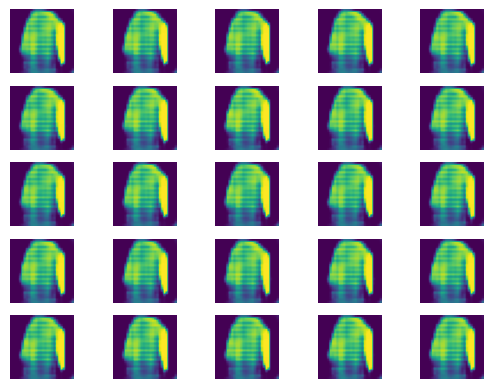

In [40]:
random_latent_vectors = tf.random.uniform((25, 128,1))
generated_images = generator(random_latent_vectors)
generated_images *= 255
generated_images.numpy()

for i in range(25):
  img = array_to_img(generated_images[i])
  plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.axis(False)